In [2]:
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import gc
import re
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import plot_tree
from scipy.cluster import hierarchy as hc
import scipy

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [5]:
# LOAD ALL AS CATEGORIES
# LOAD CSV FILE
#9 million rows originally
df_train = pd.read_csv('../data/train.csv', usecols=dtypes.keys(), low_memory=False)
print ('Loaded',len(df_train),'rows of TRAIN.CSV!')
x=gc.collect()

Loaded 8921483 rows of TRAIN.CSV!


In [6]:
isnull=df_train.isnull().sum()

In [7]:
index=isnull.index

In [8]:
values=[]
indexes=[]
for i in index:
    if isnull[i] > 0:
        indexes.append(i)
        values.append(isnull[i])
print(values)
print(indexes)

[32318, 8488045, 36221, 36221, 36221, 325409, 2751518, 213, 21, 36044, 8919174, 537759, 58894, 3177011, 91350, 10838, 95478, 102233, 41306, 41313, 41343, 8884852, 53016, 12844, 53002, 80533, 623, 47134, 46986, 46986, 55, 6338429, 268755, 60084, 7408759, 160523, 5667325, 183257, 160133, 5659703, 15953, 71343, 303451, 303451]
['RtpStateBitfield', 'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'OsBuildLab', 'IsProtected', 'PuaMode', 'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_ProcessorClass', 'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM', 'Census_ChassisTypeName', 'Census_InternalPrimaryDiagonalDi

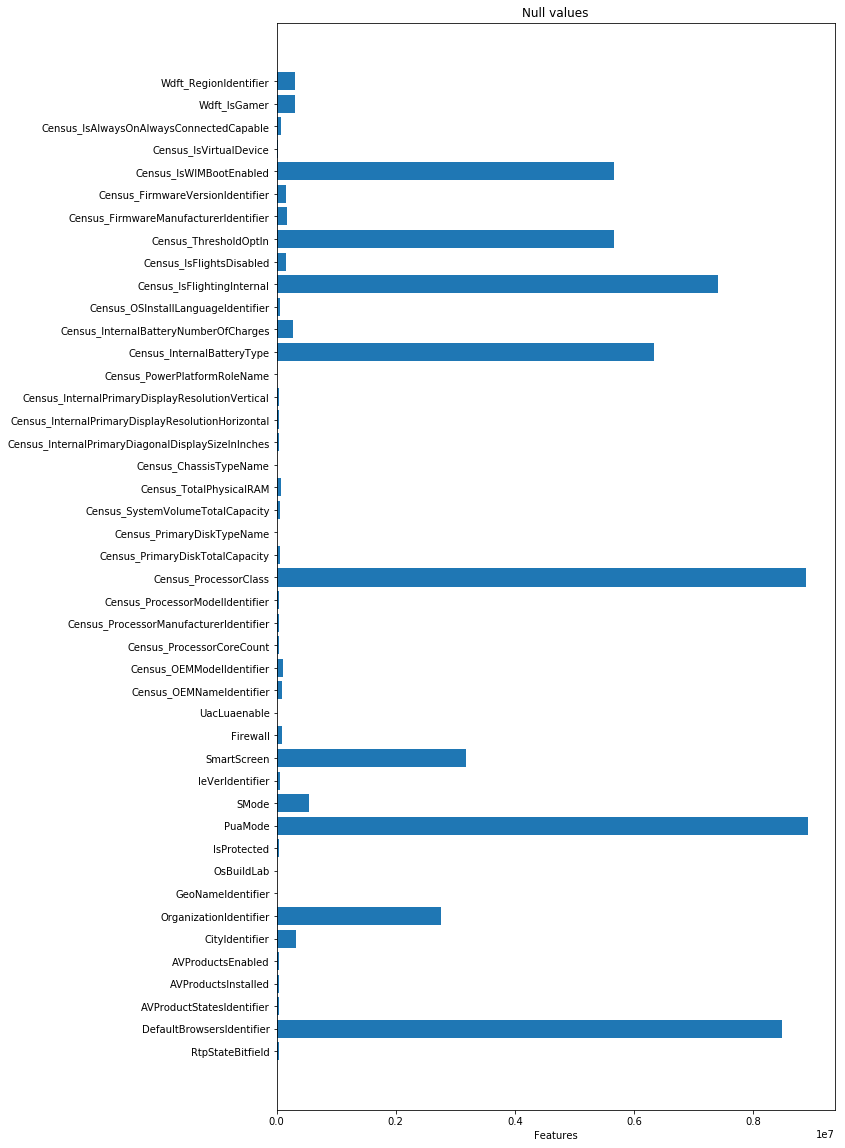

In [9]:
y_pos = np.arange(len(indexes))
plt.figure(figsize=(10, 20))
plt.barh(y_pos, values, align='center', alpha=1)
plt.yticks(y_pos, indexes)
plt.xlabel('Features')
plt.title('Null values')

plt.show()

In [10]:
for col, val in df_train.items():
    if pd.api.types.is_string_dtype(val): 
        df_train[col] = val.astype('category').cat.as_ordered()
        df_train[col] = df_train[col].cat.codes

In [11]:
for col in df_train.columns:
    print(col,len(df_train[col].unique().tolist()))

MachineIdentifier 8921483
ProductName 6
EngineVersion 70
AppVersion 110
AvSigVersion 8531
IsBeta 2
RtpStateBitfield 8
IsSxsPassiveMode 2
DefaultBrowsersIdentifier 2018
AVProductStatesIdentifier 28971
AVProductsInstalled 9
AVProductsEnabled 7
HasTpm 2
CountryIdentifier 222
CityIdentifier 107367
OrganizationIdentifier 50
GeoNameIdentifier 293
LocaleEnglishNameIdentifier 276
Platform 4
Processor 3
OsVer 58
OsBuild 76
OsSuite 14
OsPlatformSubRelease 9
OsBuildLab 664
SkuEdition 8
IsProtected 3
AutoSampleOptIn 2
PuaMode 3
SMode 3
IeVerIdentifier 304
SmartScreen 22
Firewall 3
UacLuaenable 12
Census_MDC2FormFactor 13
Census_DeviceFamily 3
Census_OEMNameIdentifier 3833
Census_OEMModelIdentifier 175366
Census_ProcessorCoreCount 46
Census_ProcessorManufacturerIdentifier 8
Census_ProcessorModelIdentifier 3429
Census_ProcessorClass 4
Census_PrimaryDiskTotalCapacity 5736
Census_PrimaryDiskTypeName 5
Census_SystemVolumeTotalCapacity 536849
Census_HasOpticalDiskDrive 2
Census_TotalPhysicalRAM 3447
Cen

In [12]:
#SPLIT TRAIN AND VALIDATION SET
X_train, X_val, Y_train, Y_val = train_test_split(
    df_train.drop(['HasDetections','MachineIdentifier'],axis=1), df_train['HasDetections'], test_size = 0.5)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_val, Y_val, test_size = 0.5)
lgb_model = lgb.LGBMClassifier(max_depth=-1,boosting_type='goss',top_rate=0.6,other_rate=0.4,
                                   n_estimators=30000,
                                   learning_rate=0.02,
                                   num_leaves=2**12-1,
                                   colsample_bytree=0.28,
                                   objective='binary', 
                                   n_jobs=-1)

In [13]:
lgb_model.fit(X_train, Y_train, eval_metric='auc', 
                  eval_set=[(X_val, Y_val)], 
                  verbose=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.6278	valid_0's auc: 0.725148
[200]	valid_0's binary_logloss: 0.609013	valid_0's auc: 0.733255
[300]	valid_0's binary_logloss: 0.600735	valid_0's auc: 0.73801
[400]	valid_0's binary_logloss: 0.597186	valid_0's auc: 0.740441
[500]	valid_0's binary_logloss: 0.594908	valid_0's auc: 0.741969
[600]	valid_0's binary_logloss: 0.593471	valid_0's auc: 0.743103
[700]	valid_0's binary_logloss: 0.592529	valid_0's auc: 0.74382
[800]	valid_0's binary_logloss: 0.59194	valid_0's auc: 0.744298
[900]	valid_0's binary_logloss: 0.591505	valid_0's auc: 0.744607
[1000]	valid_0's binary_logloss: 0.591238	valid_0's auc: 0.744781
[1100]	valid_0's binary_logloss: 0.591053	valid_0's auc: 0.744928
[1200]	valid_0's binary_logloss: 0.590941	valid_0's auc: 0.744985
[1300]	valid_0's binary_logloss: 0.590871	valid_0's auc: 0.745016
Early stopping, best iteration is:
[1264]	valid_0's binary_logloss: 0.590881	valid_0's auc: 0

LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=0.28,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=30000, n_jobs=-1, num_leaves=4095, objective='binary',
        other_rate=0.4, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, top_rate=0.6)

In [14]:

test_predictions_lgb1 = lgb_model.predict(X_test)

In [15]:
roc_auc_score(Y_test,test_predictions_lgb1)

0.6758797097524567

In [ ]:
#boosting_type='gbdt'
#1 million rows 0.6561048007182173
#9 million rows 0.6731255735923393
#9 mil rows only on categorical 0.6741954878835523
#1 mil rows only on categorical 0.6539076296269867

#boosting_type='goss',learning rate=0.05
#1 million rows 0.6441706017175877
#1 million rows 0.6463960619219077 a=0.05 b=0.05
#1 million rows 0.6456966662611934 a=0.1 b=0.1
#1 million rows 0.6552957846118314 a=0.5 b=0.5
#1 million rows 0.6542728206019701 a=0.6 b=0.3
#1 million rows 0.6550447103400406 a=0.5 b=0.3
#1 million rows 0.656357006813373 a=0.5 b=0.4
#1 million rows 0.6559393387145213 a=0.5 b=0.45
#1 million rows 0.6553770979569488 a=0.6 b=0.4


#1 million rows boosting_type='goss' a=0.5 b=0.4 
# learning rate=0.1 0.6496570255463129
# learning rate=0.03 0.6590105503619715
# learning rate=0.02 0.6590852644709204

#9 million rows boosting_type='goss' learning rate=0.02
#   a=0.5 b=0.4 0.6757044801731512 valid =0.746
#   a=0.6 b=0.4 0.6758606925213027 valid=0.745
#   a=0.1 b=0.1 0.668742883940423 valid=0.7360